In [33]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.optimize import minimize

### Simulation Data for Fitting

In [34]:
# import data
t1, y1 = np.loadtxt("data/supersat.csv", delimiter=",", skiprows=1, unpack=True)
t2, y2 = np.loadtxt("data/mu1mu0.csv", delimiter=",", skiprows=1, unpack=True)
t3, y3 = np.loadtxt("data/mu2mu0.csv", delimiter=",", skiprows=1, unpack=True)
t4, y4 = np.loadtxt("data/mu3mu0.csv", delimiter=",", skiprows=1, unpack=True)
t5, y5 = np.loadtxt("data/B.csv", delimiter=",", skiprows=1, unpack=True)
t6, y6 = np.loadtxt("data/G.csv", delimiter=",", skiprows=1, unpack=True)

# Convert mu1/mu0, mu2/mu0, mu3/mu0 from cm, cm^2, cm^3 to m, m^2, m^3
y2 = y2 * 0.01          # cm to m
y3 = y3 * 0.0001        # cm^2 to m^2
y4 = y4 * 0.000001  #   1e-11    # cm^3 to m^3

# interpolate data with linear interpolation
y1_interp = interp1d(t1, y1, kind='linear', bounds_error=False, fill_value="extrapolate")
y2_interp = interp1d(t2, y2, kind='linear', bounds_error=False, fill_value="extrapolate")
y3_interp = interp1d(t3, y3, kind='linear', bounds_error=False, fill_value="extrapolate")
y4_interp = interp1d(t4, y4, kind='linear', bounds_error=False, fill_value="extrapolate")
y5_interp = interp1d(t5, y5, kind='linear', bounds_error=False, fill_value="extrapolate")
y6_interp = interp1d(t6, y6, kind='linear', bounds_error=False, fill_value="extrapolate")

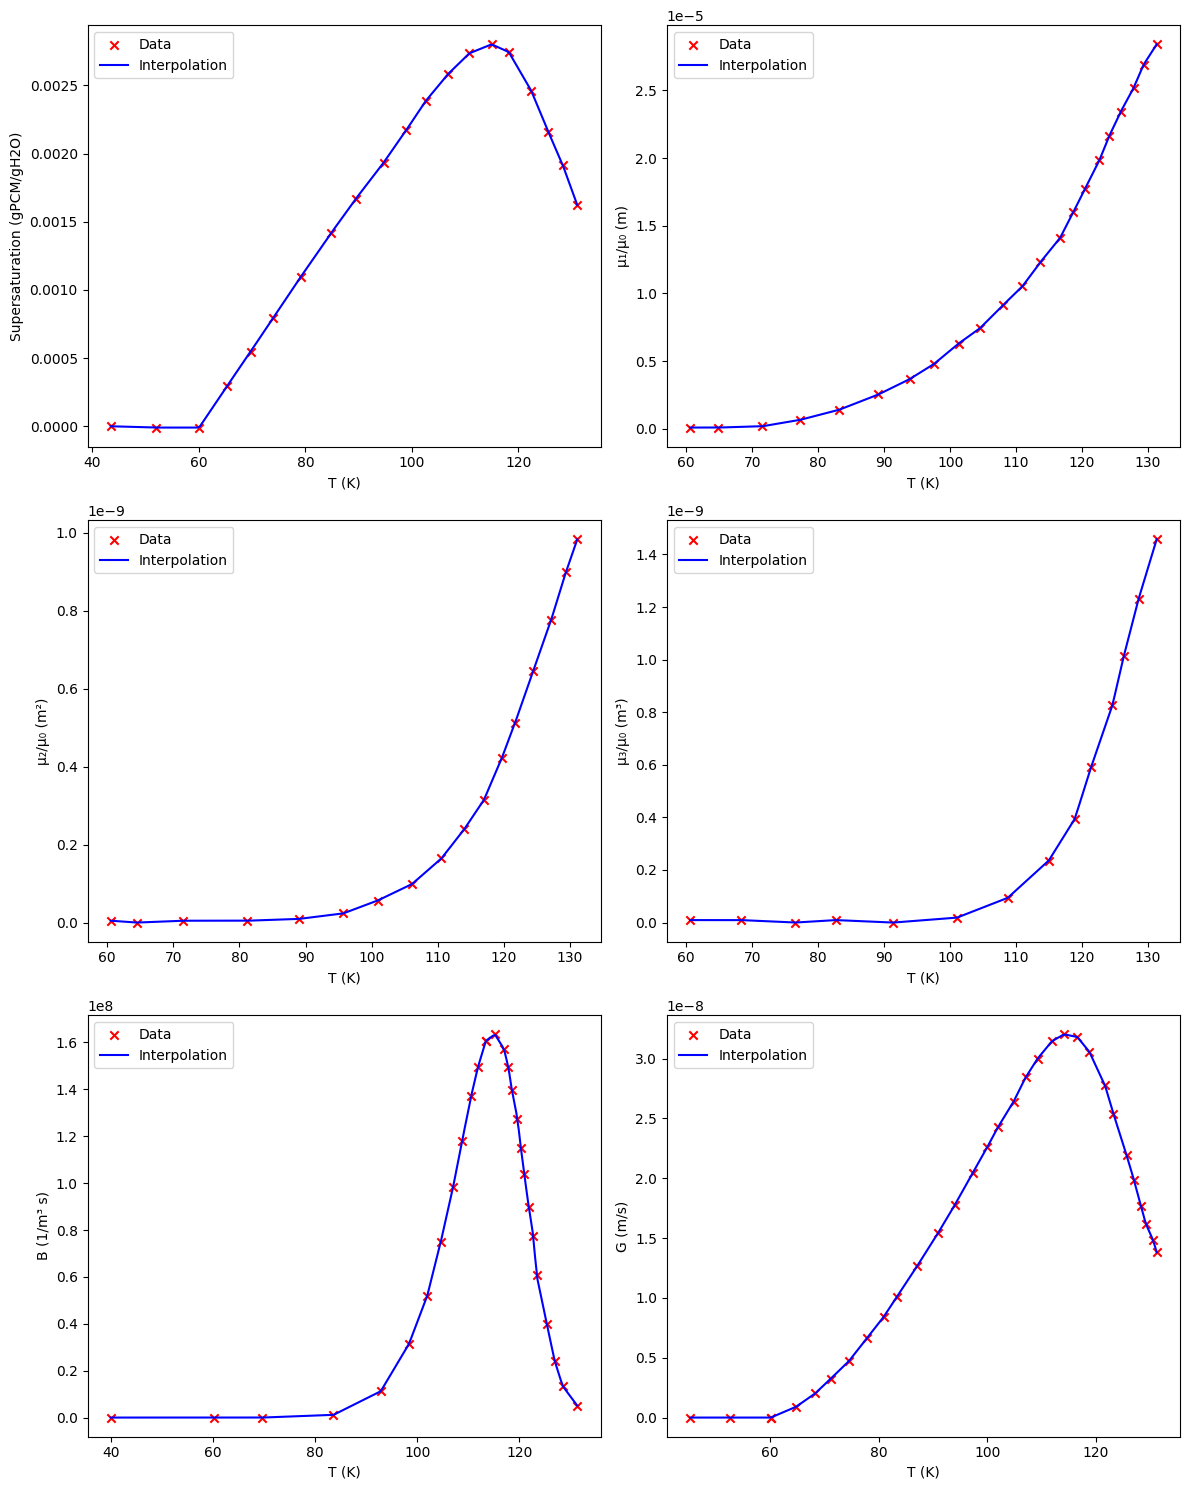

In [35]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15))

# 1. supersat.csv
axs[0, 0].scatter(t1, y1, color="red", label="Data", marker='x')
x1_plot = np.linspace(np.min(t1), np.max(t1), 200)
axs[0, 0].plot(x1_plot, y1_interp(x1_plot), color="blue", label="Interpolation")
axs[0, 0].set_xlabel("T (K)")
axs[0, 0].set_ylabel("Supersaturation (gPCM/gH2O)")
axs[0, 0].legend()

# 2. mu1mu0.csv
axs[0, 1].scatter(t2, y2, color="red", marker='x', label="Data")
x2_plot = np.linspace(np.min(t2), np.max(t2), 200)
axs[0, 1].plot(x2_plot, y2_interp(x2_plot), color="blue", label="Interpolation")
axs[0, 1].set_xlabel("T (K)")
axs[0, 1].set_ylabel("μ₁/μ₀ (m)")
axs[0, 1].legend()

# 3. mu2mu0.csv
axs[1, 0].scatter(t3, y3, color="red", marker='x', label="Data")
x3_plot = np.linspace(np.min(t3), np.max(t3), 200)
axs[1, 0].plot(x3_plot, y3_interp(x3_plot), color="blue", label="Interpolation")
axs[1, 0].set_xlabel("T (K)")
axs[1, 0].set_ylabel("μ₂/μ₀ (m²)")
axs[1, 0].legend()

# 4. mu3mu0.csv
axs[1, 1].scatter(t4, y4, color="red", marker='x', label="Data")
x4_plot = np.linspace(np.min(t4), np.max(t4), 200)
axs[1, 1].plot(x4_plot, y4_interp(x4_plot), color="blue", label="Interpolation")
axs[1, 1].set_xlabel("T (K)")
axs[1, 1].set_ylabel("μ₃/μ₀ (m³)")
axs[1, 1].legend()

# 5. B.csv
axs[2, 0].scatter(t5, y5, color="red", marker='x', label="Data")
x5_plot = np.linspace(np.min(t5), np.max(t5), 200)
axs[2, 0].plot(x5_plot, y5_interp(x5_plot), color="blue", label="Interpolation")
axs[2, 0].set_xlabel("T (K)")
axs[2, 0].set_ylabel("B (1/m³ s)")
axs[2, 0].legend()

# 6. G.csv
axs[2, 1].scatter(t6, y6, color="red", marker='x', label="Data")
x6_plot = np.linspace(np.min(t6), np.max(t6), 200)
axs[2, 1].plot(x6_plot, y6_interp(x6_plot), color="blue", label="Interpolation")
axs[2, 1].set_xlabel("T (K)")
axs[2, 1].set_ylabel("G (m/s)")
axs[2, 1].legend()

plt.tight_layout()
plt.show()

### Saturation Curve (Paracetamole in Water)

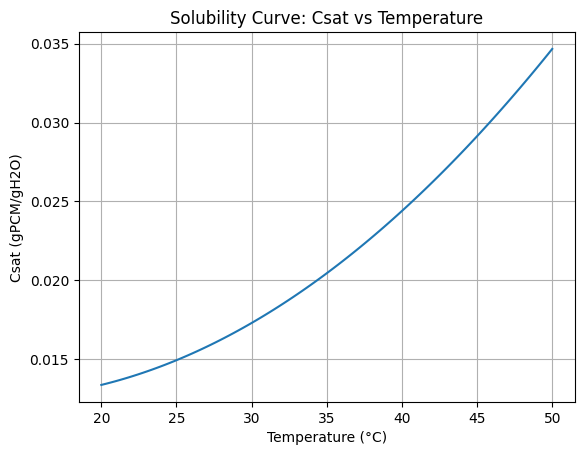

In [36]:
sat_const = 1.5846e-5, -9.0567e-03, 1.3066   # Solubility: second order polynomial, gPCM/gH2O, K, K^

def Csat(T, const=sat_const):
    """The solubility of paracetamol in water (g PCM/g water) as a function of temperature (in K)"""
    A, B, C = const
    return A*T**2 + B*T + C    # kg/m^3


T_plot = np.linspace(20+273.15, 50+273.15, 100)
Csat_vals = [Csat(T) for T in T_plot]

plt.figure()
plt.plot(T_plot - 273.15, Csat_vals)
plt.xlabel("Temperature (°C)")
plt.ylabel("Csat (gPCM/gH2O)")
plt.title("Solubility Curve: Csat vs Temperature")
plt.grid()
plt.show()

In [37]:
from scipy.optimize import root_scalar

# Given concentration to find saturation temperature for
C_target = 0.025  # gPCM/gH2O

def f(T):
    return Csat(T) - C_target

sol = root_scalar(f, bracket=[273.15+20, 273.15+100], method='brentq')
T_saturation = sol.root if sol.converged else None

print(f"Temperature at which concentration {C_target} gPCM/gH2O is saturated: {T_saturation - 273.15:.2f} °C" if T_saturation is not None else "Root not found in given range.")

print('Temp_init:',40.68 + 3.9)

Temperature at which concentration 0.025 gPCM/gH2O is saturated: 40.68 °C
Temp_init: 44.58


### State Space Model

In [38]:
kb_fit = 1.1011e+24                # Nucleation rate constant, m^-3 s^-1 (FIXED)
b_fit  = 6.196                      # Nucelation Order (FIXED)
kg_fit = 2.6868e-04                 # Growth rate constant, m/s (FIXED)
g_fit  = 1.537                      # Growth order (FIXED)

kv_guess = 1.0                      # Volumetric shape factor of prism approximated as rectangular solid
rho_cry_guess = 1400                # kg/m^3, crystal density of common stable polymorph

rad_zero = 0                        # initial radius
V = 1                             # m^3, crystallizer/liquid volume

# Fixed constants - NOT estimated (use fitted values from previous optimization)
kg_fixed = kg_fit
g_fixed = g_fit
kb_fixed = kb_fit
b_fixed = b_fit

# theta only includes the parameter to estimate: rho_cry_kv
theta_guess = [rho_cry_guess*kv_guess]


def rel_sat(C, T):
    """Cdiff = C - Csat(T)"""
    return np.maximum(0, C - Csat(T))

def B(Cdiff, kb, b):
    """Total nucleation rate (0 if undersaturated)."""
    # if Cdiff < 0:
    #     return 0.0
    return kb * Cdiff**b

def growth(Cdiff, kg, g):
    """Crystal growth rate (m/s). 0 if undersaturated or negative."""
    # if Cdiff < 0:
    #     return 0.0
    return kg * Cdiff**g

def diffeq(y, t, theta, cool_rate=3.9/3600, r=0.0):
    """
    Moment balance ODEs + solute balance.

    y = [mu0, mu1, mu2, mu3, C, T]
    Assume V = 1
    cool_rate in K/s
    """
    mu0, mu1, mu2, mu3, C, T = y
    rho_cry_kv = theta[0]

    Cdiff = rel_sat(C, T)
    N = B(Cdiff, kb_fixed, b_fixed)
    G = growth(Cdiff, kg_fixed, g_fixed)

    dmu0_dt = N
    dmu1_dt = 1 * G * mu0 + N * r**1
    dmu2_dt = 2 * G * mu1 + N * r**2
    dmu3_dt = 3 * G * mu2 + N * r**3
    rho_sol = 1000 # kg/m^3, density of solution
    dC_dt = -rho_cry_kv/rho_sol * (3 * G * mu2 + N * r**3)  # mass of crystals per m^3 per s
    dT_dt = -cool_rate

    return [dmu0_dt, dmu1_dt, dmu2_dt, dmu3_dt, dC_dt, dT_dt]


def g(x, t, theta, cool_rate=3.9/3600):
    mu0, mu1, mu2, mu3, C, T = x[:,0], x[:,1], x[:,2], x[:,3], x[:,4], x[:,5]
    rho_cry_kv = theta[0]
    T = T[0] - cool_rate * t
    Cdiff = rel_sat(C, T)
    
    y1 = Cdiff
    # Avoid divide by zero: where mu0==0, set quantity to zero
    y2 = np.zeros_like(mu0)
    y3 = np.zeros_like(mu0)
    y4 = np.zeros_like(mu0)
    nonzero = mu0 != 0
    y2[nonzero] = mu1[nonzero] / mu0[nonzero]
    y3[nonzero] = mu2[nonzero] / mu0[nonzero]
    y4[nonzero] = mu3[nonzero] / mu0[nonzero]

    y5 = np.zeros_like(Cdiff)
    y5[nonzero] = B(Cdiff[nonzero], kb_fixed, b_fixed)
    y6 = np.zeros_like(Cdiff)
    y6[nonzero] = growth(Cdiff[nonzero], kg_fixed, g_fixed)  

    return [y1, y2, y3, y4, y5, y6]

### Parameter Fit

In [39]:
# Initial conditions
mu0_0 = mu1_0 = mu2_0 = mu3_0 = 0.0
C_0 = 0.025
T_0 = 44.58 + 273.15
t_array = np.linspace(0, 130*60, 1000)
cool_rate = 3.9/3600

state_init = [mu0_0, mu1_0, mu2_0, mu3_0, C_0, T_0]


# Normalized Absolute Error (NAE)
def objective(theta):
    sol = odeint(diffeq, state_init, t_array, args=(theta, cool_rate))
    output = g(sol, t_array, theta, cool_rate)
    y1_fit = output[0]
    y2_fit = output[1]
    y3_fit = output[2]
    y4_fit = output[3]
    y5_fit = output[4]
    y6_fit = output[5]

    # Evaluate ground truth y1-y6 at simulation time points
    y1_true = y1_interp(t_array/60)
    y2_true = y2_interp(t_array/60)
    y3_true = y3_interp(t_array/60)
    y4_true = y4_interp(t_array/60)
    y5_true = y5_interp(t_array/60)
    y6_true = y6_interp(t_array/60)
    
    # Normalize by the max or mean of each variable (not pointwise)
    scale1 = np.max(np.abs(y1_true)) + 1e-10
    scale2 = np.max(np.abs(y2_true)) + 1e-10
    scale3 = np.max(np.abs(y3_true)) + 1e-10
    scale4 = np.max(np.abs(y4_true)) + 1e-10
    scale5 = np.max(np.abs(y5_true)) + 1e-10
    scale6 = np.max(np.abs(y6_true)) + 1e-10
    
    return (
        np.sum(((y1_fit - y1_true) / scale1) ** 2) +
        np.sum(((y2_fit - y2_true) / scale2) ** 2) +
        np.sum(((y3_fit - y3_true) / scale3) ** 2) +
        np.sum(((y4_fit - y4_true) / scale4) ** 2) +
        np.sum(((y5_fit - y5_true) / scale5) ** 2) +
        np.sum(((y6_fit - y6_true) / scale6) ** 2)
    )

theta_guess = [rho_cry_guess*kv_guess]
from scipy.optimize import Bounds

# Set lower and upper bounds for rho_cry_kv only
lower_bounds = [0]
upper_bounds = [2000]
bounds = Bounds(lower_bounds, upper_bounds)

theta_fit = minimize(objective, theta_guess, method='Nelder-Mead', bounds=bounds)
print(f"Fitted rho_cry_kv: {theta_fit.x[0]:.2f} kg/m³")

Fitted rho_cry_kv: 314.68 kg/m³


In [ ]:
sol = odeint(diffeq, state_init, t_array, args=(theta_fit.x, cool_rate))

output = g(sol, t_array, theta_fit.x, cool_rate)
y1_fit = output[0]
y2_fit = output[1]
y3_fit = output[2]
y4_fit = output[3]
y5_fit = output[4]
y6_fit = output[5]

# Save arrays to .npz file to use in other notebooks
np.savez('results/y_final.npz', 
         t_array=t_array, 
         y1=y1_fit, 
         y2=y2_fit,
         y3=y3_fit, 
         y4=y4_fit, 
         y5=y5_fit, 
         y6=y6_fit)

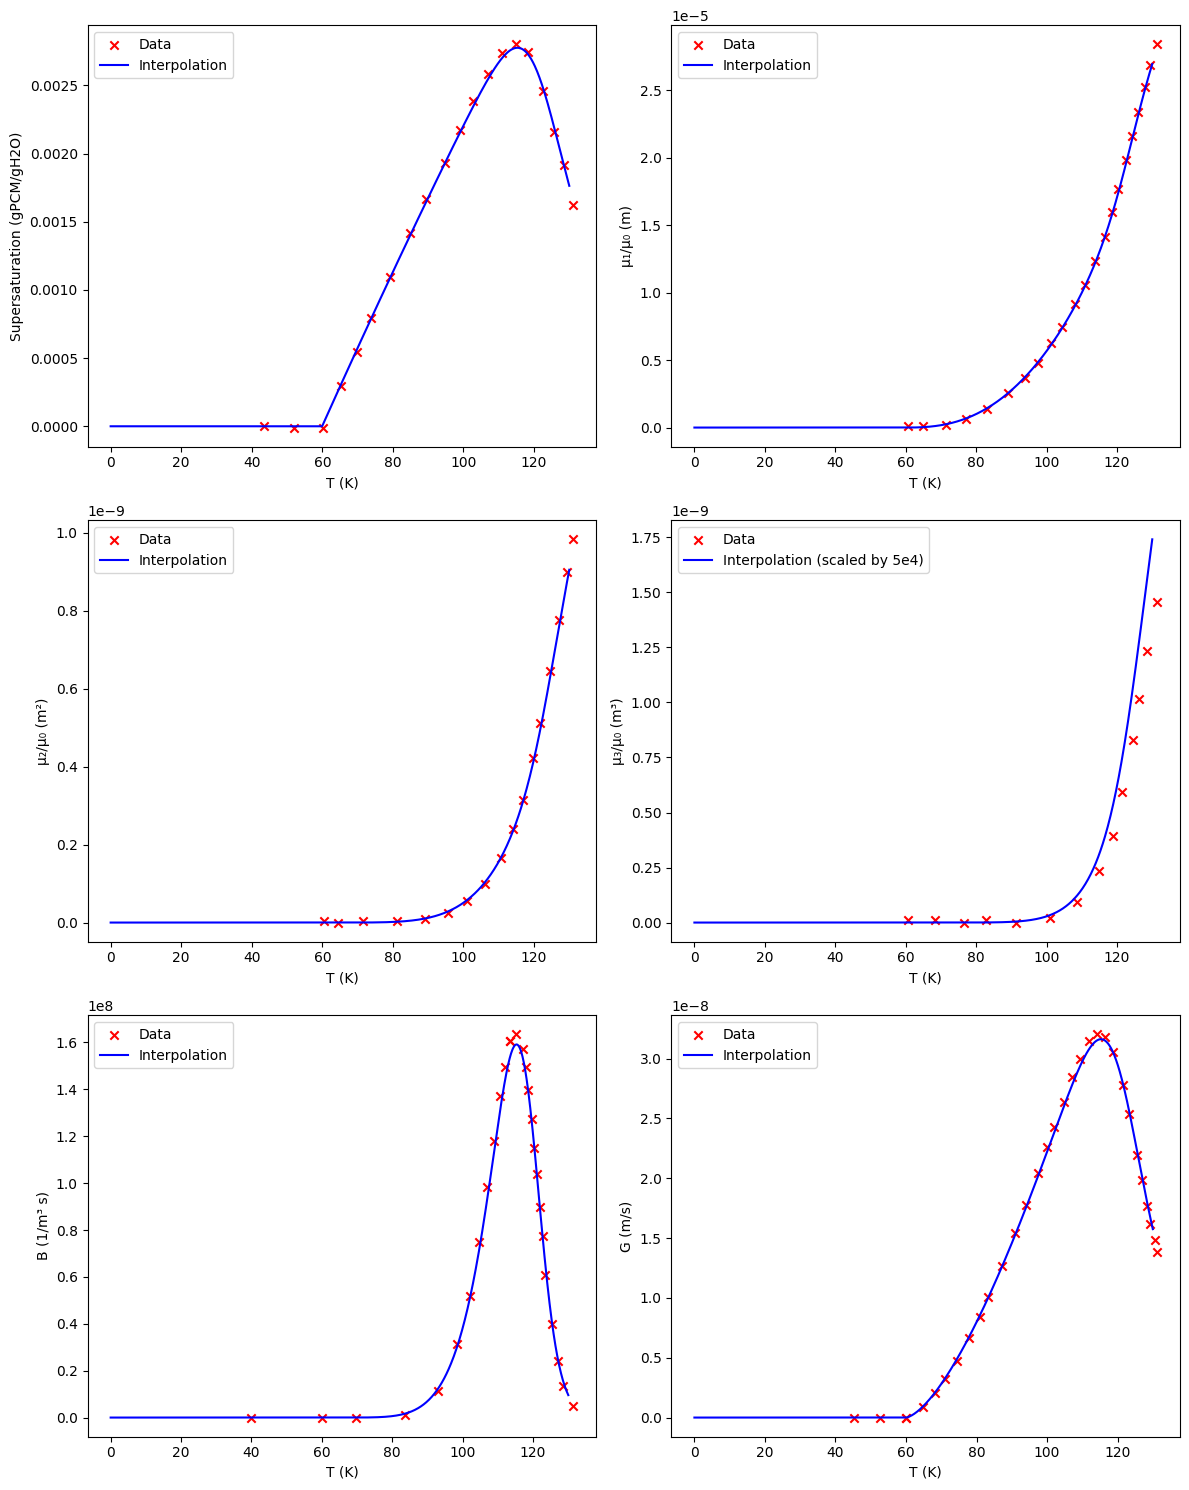

In [54]:


t_array_scaled = t_array/60

fig, axs = plt.subplots(3, 2, figsize=(12, 15))

# 1. supersat.csv
axs[0, 0].scatter(t1, y1, color="red", label="Data", marker='x')
x1_interp = np.linspace(np.min(t1), np.max(t1), 200)
axs[0, 0].plot(t_array_scaled, y1_fit, color="blue", label="Interpolation")
axs[0, 0].set_xlabel("T (K)")
axs[0, 0].set_ylabel("Supersaturation (gPCM/gH2O)")
axs[0, 0].legend()

# 2. mu1mu0.csv
axs[0, 1].scatter(t2, y2, color="red", marker='x', label="Data")
x2_interp = np.linspace(np.min(t2), np.max(t2), 200)
axs[0, 1].plot(t_array_scaled, y2_fit, color="blue", label="Interpolation")
axs[0, 1].set_xlabel("T (K)")
axs[0, 1].set_ylabel("μ₁/μ₀ (m)")
axs[0, 1].legend()

# 3. mu2mu0.csv
axs[1, 0].scatter(t3, y3, color="red", marker='x', label="Data")
x3_interp = np.linspace(np.min(t3), np.max(t3), 200)
axs[1, 0].plot(t_array_scaled, y3_fit, color="blue", label="Interpolation")
axs[1, 0].set_xlabel("T (K)")
axs[1, 0].set_ylabel("μ₂/μ₀ (m²)")
axs[1, 0].legend()

# 4. mu3mu0.csv
axs[1, 1].scatter(t4, y4, color="red", marker='x', label="Data")
x4_interp = np.linspace(np.min(t4), np.max(t4), 200)
axs[1, 1].plot(t_array_scaled, y4_fit*5e4, color="blue", label="Interpolation (scaled by 5e4)")
axs[1, 1].set_xlabel("T (K)")
axs[1, 1].set_ylabel("μ₃/μ₀ (m³)")
axs[1, 1].legend()

# 5. B.csv
axs[2, 0].scatter(t5, y5, color="red", marker='x', label="Data")
x5_interp = np.linspace(np.min(t5), np.max(t5), 200)
axs[2, 0].plot(t_array_scaled, y5_fit, color="blue", label="Interpolation")
axs[2, 0].set_xlabel("T (K)")
axs[2, 0].set_ylabel("B (1/m³ s)")
axs[2, 0].legend()

# 6. G.csv
axs[2, 1].scatter(t6, y6, color="red", marker='x', label="Data")
x6_interp = np.linspace(np.min(t6), np.max(t6), 200)
axs[2, 1].plot(t_array_scaled, y6_fit, color="blue", label="Interpolation")
axs[2, 1].set_xlabel("T (K)")
axs[2, 1].set_ylabel("G (m/s)")
axs[2, 1].legend()

plt.tight_layout()
plt.show()


In [57]:
t_sim = np.linspace(0, 360*60, 1000)
sol = odeint(diffeq, state_init, t_sim, args=(theta_fit.x, cool_rate))

mu0 = sol[:, 0]
mu1 = sol[:, 1]
mu2 = sol[:, 2]
mu3 = sol[:, 3]
C = sol[:, 4]
T = sol[:, 5]

np.savez('results/sol_final.npz', 
         t_array = t_sim,
         mu0=mu0, 
         mu1=mu1, 
         mu2=mu2,
         mu3=mu3,
         C = C,
         T = T)